# Assignment 2  - Part A  - PyTorch


#### Roll Number: 2022-10-0001

### Task Explanation

In this part we will implement, train and evaluate a neural network using pyTorch on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score


# any other imports that you may require
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

The following code decides whether to run on GPU or CPU. You can have a look [here](https://pytorch.org/docs/stable/notes/cuda.html) to understand how to use this here in this task.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

You can play with these to improve accuracy on test data.

In [ ]:
batch_size = 8
epochs = 30
learning_rate = 0.0001
input_shape = (256,256)

### Data

Get Wheat Disease Data for training and testing

In [ ]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

Cloning into 'WheatDiseaseDataset'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 386.05 MiB | 34.54 MiB/s, done.
Checking out files: 100% (877/877), done.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [ ]:
! ls -l /content/WheatDiseaseDataset/train/

total 28
drwxr-xr-x 2 root root  4096 Feb 27 18:23 healthy_wheat
drwxr-xr-x 2 root root 12288 Feb 27 18:23 leaf_rust
drwxr-xr-x 2 root root 12288 Feb 27 18:23 stem_rust


In [ ]:
# code here
training_paths = []
files = glob.glob("/content/WheatDiseaseDataset/train/**/*", recursive = False)
for file in files:
  training_paths.append(file)
print("Length of training paths {}".format(len(training_paths)))

Length of training paths 699


Do the same for testing data images.

In [ ]:
# code here
testing_paths = []
files = glob.glob("/content/WheatDiseaseDataset/test/**/*", recursive = False)
for file in files:
  testing_paths.append(file)
print("Length of training paths {}".format(len(testing_paths)))

Length of training paths 177


### Labels

In [ ]:
my_labels={}
my_labels['healthy_wheat'] = 0
my_labels['leaf_rust'] = 1
my_labels['stem_rust'] = 2

### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [ ]:
def preprocessing_norm(images):
    images = images / 255
    return images

### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. 

We will use a data generator function and a pytorch DataLoader to generate batches of images.

Our data generator function will return all images and labels in a list of  tuples of (Xs,Ys).


For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:

- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Preprocess images
- Pytorch accepts channels-first input style. So transpose the images. (Hint: see np.transpose())
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- No need to one-hot encode here.
- return  images and labels in a list of tuples.



In [ ]:
# Data generator function here. 
def data_generator(img_path_list):
  
  return_list = []
  num_samples = len(img_path_list)
  
  for img_path in img_path_list:
 
    im_cv = cv2.imread(img_path)
    im_cv = im_cv.astype(np.float32)
    # im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
    im_cv = cv2.resize(im_cv, input_shape)
    im_cv = np.transpose(preprocessing_norm(im_cv))
    
    label = re.split("/", img_path)[4]
    label = my_labels[label] # convert to numeric label

    return_list.append((im_cv, label))
    
  return return_list



In [ ]:
# im_cv = cv2.imread(testing_paths[6])
# im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
# # print(im_rgb.shape)

In [ ]:
# from matplotlib.pyplot import imshow
# print(type(im_rgb))
# imshow(im_rgb)

Initialize train data generator using a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=return%20image%2C%20label-,Preparing%20your%20data%20for%20training%20with%20DataLoaders,-The%20Dataset%20retrieves), we will pass the batch generator function to the DataLoader.

the data generator function will provide all the data and the data loader can then divide it into batches using the `batch_size` argument.

In [ ]:
# code here

# create a training loader
training_loader = DataLoader(data_generator(training_paths), batch_size=batch_size, shuffle=True)

# create a validation loader from test data -> split test data in half to make validation set
validation_paths, testing_paths = train_test_split(testing_paths, test_size=0.5, random_state=42)

# create a validation loader
validation_loader = DataLoader(data_generator(validation_paths), batch_size=batch_size, shuffle=True)


### Task 1

### Training

Define network class here. You can have a look [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to understand how this works.

Model architecture is provided in model1.png


- Stride = 2, Padding = 0 for all convolutional layers
- Dropout ratio is 0.2
- Kernel size = 5 for first Convolutional layer
- Kernel size = 3 for rest of the layers.

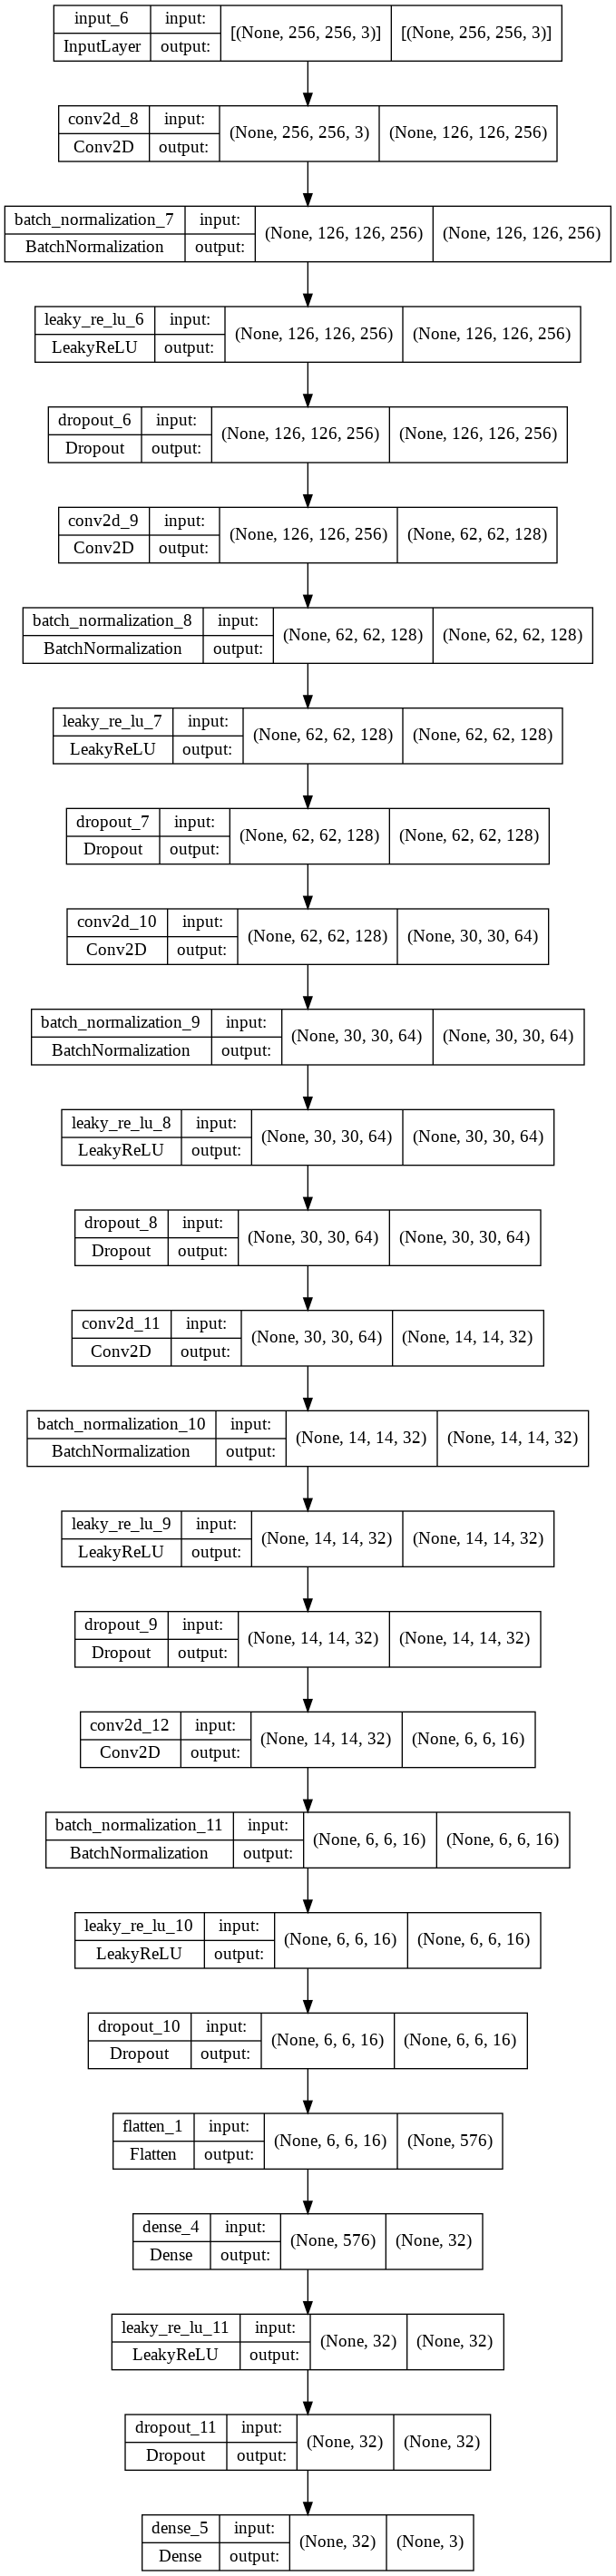

In [ ]:
# code here
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv8 = nn.Conv2d(3, 256, 5, stride=2, padding=0)
        self.norm7 = nn.BatchNorm2d(256)
        self.lrelu6 = nn.LeakyReLU()
        self.dropout6 = nn.Dropout(p=0.2)
        
        self.conv9 = nn.Conv2d(256, 128, 3, stride=2, padding=0)
        self.norm8 = nn.BatchNorm2d(128)
        self.lrelu7 = nn.LeakyReLU()
        self.dropout7 = nn.Dropout(p=0.2)

        self.conv10 = nn.Conv2d(128, 64, 3, stride=2, padding=0)
        self.norm9 = nn.BatchNorm2d(64)
        self.lrelu8 = nn.LeakyReLU()
        self.dropout8 = nn.Dropout(p=0.2)

        self.conv11 = nn.Conv2d(64, 32, 3, stride=2, padding=0)
        self.norm10 = nn.BatchNorm2d(32)
        self.lrelu9 = nn.LeakyReLU()
        self.dropout9 = nn.Dropout(p=0.2)

        self.conv12 = nn.Conv2d(32, 16, 3, stride=2, padding=0)
        self.norm11 = nn.BatchNorm2d(16)
        self.lrelu10 = nn.LeakyReLU()
        self.dropout10 = nn.Dropout(p=0.2)

        self.flatten1 = nn.Flatten()
        self.dense4 = nn.Linear(576, 32)
        self.lrelu11 = nn.LeakyReLU()
        self.dropout10 = nn.Dropout(p=0.2)
        self.dense5 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.dropout6(self.lrelu6(self.norm7(self.conv8(x))))
        x = self.dropout7(self.lrelu7(self.norm8(self.conv9(x))))
        x = self.dropout8(self.lrelu8(self.norm9(self.conv10(x))))
        x = self.dropout9(self.lrelu9(self.norm10(self.conv11(x))))
        x = self.dropout10(self.lrelu10(self.norm11(self.conv12(x))))
        # x = self.flatten1(x)
        x = torch.flatten(x, 1)
        x = self.dense4(x)
        x = self.dense5(self.dropout10(self.lrelu11(x)))

        return x


Initialize network and cast it to device declared above. (Hint: net.to(device) )

In [ ]:
# code here
model = ConvNet().to(device)

In [ ]:
#print model summary here
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
         LeakyReLU-3        [-1, 256, 126, 126]               0
           Dropout-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
         LeakyReLU-7          [-1, 128, 62, 62]               0
           Dropout-8          [-1, 128, 62, 62]               0
            Conv2d-9           [-1, 64, 30, 30]          73,792
      BatchNorm2d-10           [-1, 64, 30, 30]             128
        LeakyReLU-11           [-1, 64, 30, 30]               0
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 32, 14, 14]          18,464
      BatchNorm2d-14           [-1, 32,

Define [CrossEntropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [RMSprop](https://pytorch.org/docs/stable/optim.html#:~:text=Implements%20RAdam%20algorithm.-,RMSprop,-Implements%20RMSprop%20algorithm) optimizer here. (Hint: See the links to understand how to do this.)

In [ ]:
# Code here
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
# Intialize num_training_batches.
num_training_batches = len(training_paths) / batch_size

Train the network here. You can have look [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=0.001%2C%20momentum%3D0.9) to understand how to do this. Remember to convert your data and labels to pytorch tensors and cast to device before passing it to the network. Also, record the training loss for plotting purposes.

In [ ]:
# code here

# code taken from: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=0.001%2C%20momentum%3D0.9

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    counter = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = torch.tensor(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        counter +=1
   
    last_loss = running_loss / counter # loss per batch
    return last_loss


In [ ]:
# Train the model for different epochs, save model after each epoch
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

train_loss_list = []

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_list.append(avg_loss) # append to list for plotting

    # We don't need gradients on to do reporting
    model.train(False)

    print('LOSS train {}'.format(avg_loss))

    # Save the model's state
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


LOSS train 0.9804322436877659
EPOCH 2:
LOSS train 0.8366917051587786
EPOCH 3:
LOSS train 0.7774943573134286
EPOCH 4:
LOSS train 0.7704182005780084
EPOCH 5:
LOSS train 0.7003978453363691
EPOCH 6:
LOSS train 0.6595323613711765
EPOCH 7:
LOSS train 0.5844493909393038
EPOCH 8:
LOSS train 0.5813900137586253
EPOCH 9:
LOSS train 0.49834131843277385
EPOCH 10:
LOSS train 0.45316701854978286
EPOCH 11:
LOSS train 0.41471442714333534
EPOCH 12:
LOSS train 0.388374977431127
EPOCH 13:
LOSS train 0.34868494560143776
EPOCH 14:
LOSS train 0.34593093042128853
EPOCH 15:
LOSS train 0.2623509087413549
EPOCH 16:
LOSS train 0.2716240022876965
EPOCH 17:
LOSS train 0.243732912737344
EPOCH 18:
LOSS train 0.15386816657846794
EPOCH 19:
LOSS train 0.21350740077240127
EPOCH 20:
LOSS train 0.18021795996331744
EPOCH 21:
LOSS train 0.2044359689605023
EPOCH 22:
LOSS train 0.1976104802498594
EPOCH 23:
LOSS train 0.1754208430884007
EPOCH 24:
LOSS train 0.13312011186731978
EPOCH 25:
LOSS train 0.1588802782134735


In [ ]:
# Find the best model using the validation set
def validate_one_epoch():
  # Load the saved model
  PATH = "/content/drive/MyDrive/Deep Learning/saved_models/model_20220226_135726_" + str(epoch)
  saved_model = ConvNet().to(device)
  saved_model.load_state_dict(torch.load(PATH))

  saved_model.train(False)
  saved_model.eval()

  with torch.no_grad():  
    # We don't need gradients on to do reporting

    running_vloss = 0.0
    counter = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = torch.tensor(vinputs)
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = saved_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        counter +=1

        del vinputs, vlabels, voutputs

    del saved_model

  return (running_vloss / counter).cpu().numpy()

epoch_number = 0

best_vloss = 1_000_000.
valid_loss_list = []
best_epoch_number = 0

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    torch.cuda.empty_cache()

    avg_vloss = validate_one_epoch()

    valid_loss_list.append(avg_vloss) # append to list for plotting
    print('LOSS valid {}'.format(avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch_number = epoch

    epoch_number += 1

print("model with least validation loss was at epoch {}".format(best_epoch_number))

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


LOSS valid 0.9022300243377686
EPOCH 2:
LOSS valid 0.8049737215042114
EPOCH 3:
LOSS valid 0.7294001579284668
EPOCH 4:
LOSS valid 0.6941410899162292
EPOCH 5:
LOSS valid 0.7591249346733093
EPOCH 6:
LOSS valid 0.6313288807868958
EPOCH 7:
LOSS valid 0.7265898585319519
EPOCH 8:
LOSS valid 0.6084185838699341
EPOCH 9:
LOSS valid 0.7647491097450256
EPOCH 10:
LOSS valid 0.6249111294746399
EPOCH 11:
LOSS valid 0.5483914613723755
EPOCH 12:
LOSS valid 0.7502939105033875
EPOCH 13:
LOSS valid 0.6190106272697449
EPOCH 14:
LOSS valid 0.600713849067688
EPOCH 15:
LOSS valid 0.916999340057373
EPOCH 16:
LOSS valid 0.8680203557014465
EPOCH 17:
LOSS valid 0.5753128528594971
EPOCH 18:
LOSS valid 0.6036486029624939
EPOCH 19:
LOSS valid 0.490009069442749
EPOCH 20:
LOSS valid 0.8892268538475037
EPOCH 21:
LOSS valid 0.9052421450614929
EPOCH 22:
LOSS valid 0.7351834177970886
EPOCH 23:
LOSS valid 0.9583691358566284
EPOCH 24:
LOSS valid 1.0647915601730347
EPOCH 25:
LOSS valid 1.5536781549453735
model with least vali

Plot the loss graph of training.

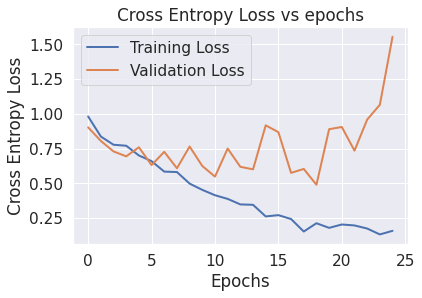

In [ ]:
# Loss Plot
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots()

ax.plot(range(epochs), train_loss_list, linewidth=2.0, label="Training Loss")
ax.plot(range(epochs), valid_loss_list, linewidth=2.0, label="Validation Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('Cross Entropy Loss vs epochs')

plt.legend()
plt.show()

**Train Loss goes down, Validation loss goes up. This shows overfitting. When epoch = 18, validaiton loss is least, so use this as final model for evaluating on test dataset**

### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

In [ ]:
# code here
testing_loader = DataLoader(data_generator(testing_paths), batch_size=len(testing_paths), shuffle=True)

Put the network in eval mode using your_model.eval()

In [ ]:
# code here
best_epoch = 18
PATH = "/content/drive/MyDrive/Deep Learning/saved_models/model_20220226_135726_" + str(best_epoch)
saved_model = ConvNet().to(device)
saved_model.load_state_dict(torch.load(PATH))

saved_model.eval()


ConvNet(
  (conv8): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (norm7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu6): LeakyReLU(negative_slope=0.01)
  (dropout6): Dropout(p=0.2, inplace=False)
  (conv9): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu7): LeakyReLU(negative_slope=0.01)
  (dropout7): Dropout(p=0.2, inplace=False)
  (conv10): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (norm9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu8): LeakyReLU(negative_slope=0.01)
  (dropout8): Dropout(p=0.2, inplace=False)
  (conv11): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (norm10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu9): LeakyReLU(negative_slope=0.01)
  (dropout9): Dropout(p=0.2, inplace=False)
  (conv12): Conv2d(32, 16, 

Now, make predictions on test data. Cast the outputs to cpu and convert to numpy (using outputs.cpu().numpy()). If you get memory error then you can loop over all images one by one and then make and store the prediction.

In [ ]:
# code here
with torch.no_grad():
  y_true = 0
  y_pred = 0

  for images, labels in testing_loader:
    images = torch.tensor(images)
    images = images.to(device)
    labels = labels.to(device)
    outputs = saved_model(images)
    # outputs are the prediction done by the model
    y_pred = outputs.cpu().numpy()
    y_true = labels.cpu().numpy()
    break

Extract class label from predictions. (Hint: you can use np.argmax() ).

In [ ]:
# code here
y_pred = np.argmax(y_pred, 1)

Calculate and print accuracy.

In [ ]:
# code here
accuracy = sum(y_true == y_pred) / len(y_pred) * 100
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 75.55555555555556


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [ ]:
# code here
temp = confusion_matrix(y_true, y_pred)

In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(my_labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

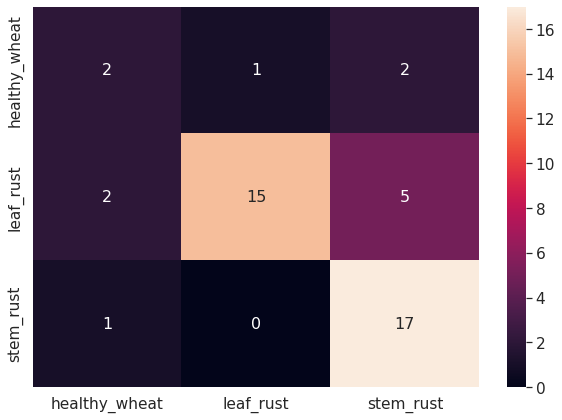

In [ ]:
# code here
plot_confusion_matrix(temp)

### Task 2




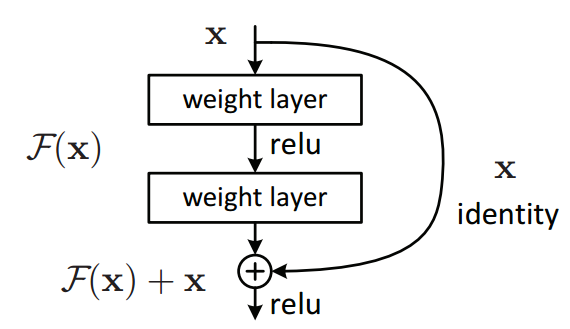

Now we'll add a skip connection to the convolutional network we have prepared .

These skip connections are the foundation for ResNet models which have produced state of the art results on datasets.

Here is the sample architecture:


- Kernel size = 5, Stride = 2 for first convolution.
- Kernel size = 1, Stride = 1 for second convolution.
- No padding required
- Dropout is 0.2

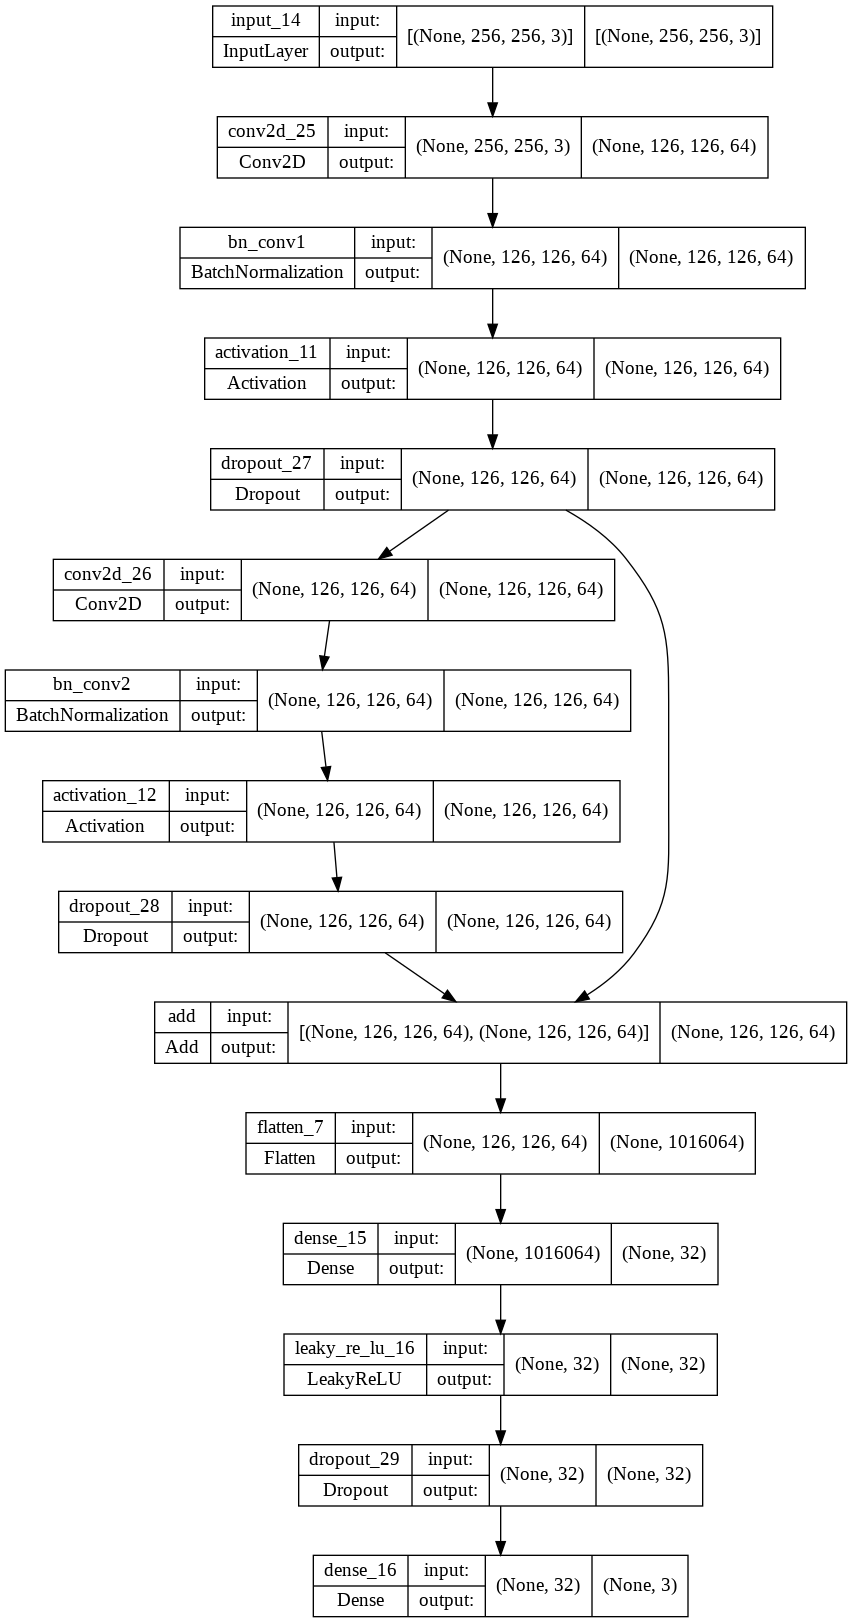

Define Network class

In [ ]:
# Code here
class SkipNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv25 = nn.Conv2d(3, 64, 5, stride=2, padding=0)
        self.norm1 = nn.BatchNorm2d(64)
        self.lrelu11 = nn.ReLU()
        self.dropout27 = nn.Dropout(p=0.2)
        
        self.conv26 = nn.Conv2d(64, 64, 1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(64)
        self.lrelu12 = nn.ReLU()
        self.dropout28 = nn.Dropout(p=0.2)

        self.flatten7 = nn.Flatten()
        self.dense15 = nn.Linear(1016064, 32)
        self.lrelu16 = nn.LeakyReLU()
        self.dropout29 = nn.Dropout(p=0.2)
        self.dense16 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.dropout27(self.lrelu11(self.norm2(self.conv25(x))))
        x1 = x
        x = self.dropout28(self.lrelu12(self.norm2(self.conv26(x))))
        x = x1 + x
        # x = self.flatten1(x)
        x = torch.flatten(x, 1)
        x = self.dense15(x)
        x = self.dense16(self.dropout29(self.lrelu16(x)))

        return x


Initialize model and cast it to device

In [ ]:
del model

In [ ]:
# Code here
model = SkipNet().to(device)

Print Summary

In [ ]:
# Code here
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           4,864
       BatchNorm2d-2         [-1, 64, 126, 126]             128
              ReLU-3         [-1, 64, 126, 126]               0
           Dropout-4         [-1, 64, 126, 126]               0
            Conv2d-5         [-1, 64, 126, 126]           4,160
       BatchNorm2d-6         [-1, 64, 126, 126]             128
              ReLU-7         [-1, 64, 126, 126]               0
           Dropout-8         [-1, 64, 126, 126]               0
            Linear-9                   [-1, 32]      32,514,080
        LeakyReLU-10                   [-1, 32]               0
          Dropout-11                   [-1, 32]               0
           Linear-12                    [-1, 3]              99
Total params: 32,523,459
Trainable params: 32,523,459
Non-trainable params: 0
-------------------------

Define loss, optimizer and train the new model 

In [ ]:
# Code here
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
num_training_batches = len(training_paths) / batch_size

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    counter = 0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = torch.tensor(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        counter +=1
   
    last_loss = running_loss / counter # loss per batch
    return last_loss

def validate_one_epoch(saved_models_directory):
  # Load the saved model
  PATH = saved_models_directory + str(epoch)
  saved_model = SkipNet().to(device)
  saved_model.load_state_dict(torch.load(PATH))

  saved_model.train(False)
  saved_model.eval()

  with torch.no_grad():  
    running_vloss = 0.0
    counter = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = torch.tensor(vinputs)
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = saved_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        counter +=1
        del vinputs, vlabels, voutputs
    del saved_model
  return (running_vloss / counter).cpu().numpy()

In [ ]:
# ------ Train model on training set ------
epoch_number = 0

train_loss_list = []

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_list.append(avg_loss) # append to list for plotting

    # We don't need gradients on to do reporting
    model.train(False)

    print('LOSS train {}'.format(avg_loss))

    # Save the model's state
    model_path = '/content/drive/MyDrive/Deep Learning/A2/P1T2/model_{}'.format(epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


LOSS train 13.39728334141629
EPOCH 2:
LOSS train 1.3033339211770467
EPOCH 3:
LOSS train 1.2562911253316063
EPOCH 4:
LOSS train 1.0722970900365285
EPOCH 5:
LOSS train 1.0418908837863377
EPOCH 6:
LOSS train 1.289949980207852
EPOCH 7:
LOSS train 1.543515841279711
EPOCH 8:
LOSS train 0.7982143328265686
EPOCH 9:
LOSS train 0.8470302785664638
EPOCH 10:
LOSS train 0.46111584105844095
EPOCH 11:
LOSS train 1.1853097499394374
EPOCH 12:
LOSS train 0.5998392615538588
EPOCH 13:
LOSS train 0.5438392898966421
EPOCH 14:
LOSS train 0.623907023690712
EPOCH 15:
LOSS train 0.7898085701489409
EPOCH 16:
LOSS train 0.7952475762631563
EPOCH 17:
LOSS train 0.4596858011474212
EPOCH 18:
LOSS train 0.21754509119254115
EPOCH 19:
LOSS train 0.4271246403102691
EPOCH 20:
LOSS train 0.47872397162918967
EPOCH 21:
LOSS train 0.5213892826944768
EPOCH 22:
LOSS train 0.41904062797836017
EPOCH 23:
LOSS train 0.2792645459346344
EPOCH 24:
LOSS train 0.32861799046114487
EPOCH 25:
LOSS train 0.472527592326283
EPOCH 26:
LOSS tra

In [ ]:
# Find the model with least validaiton loss
epoch_number = 0
best_vloss = 1_000_000.
valid_loss_list = []
best_epoch_number = 0

model_directory = '/content/drive/MyDrive/Deep Learning/A2/P1T2/model_'

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))
    torch.cuda.empty_cache()
    avg_vloss = validate_one_epoch(model_directory)
    valid_loss_list.append(avg_vloss) # append to list for plotting
    print('LOSS valid {}'.format(avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch_number = epoch

    epoch_number += 1

print("model with least validation loss was at epoch {}".format(best_epoch_number))

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


LOSS valid 1.0500394105911255
EPOCH 2:
LOSS valid 1.0260756015777588
EPOCH 3:
LOSS valid 1.0580029487609863
EPOCH 4:
LOSS valid 0.9778587222099304
EPOCH 5:
LOSS valid 0.9728147387504578
EPOCH 6:
LOSS valid 1.2894632816314697
EPOCH 7:
LOSS valid 1.0630613565444946
EPOCH 8:
LOSS valid 1.3838624954223633
EPOCH 9:
LOSS valid 1.1181838512420654
EPOCH 10:
LOSS valid 0.9238566756248474
EPOCH 11:
LOSS valid 2.8855865001678467
EPOCH 12:
LOSS valid 0.9895719289779663
EPOCH 13:
LOSS valid 2.2731175422668457
EPOCH 14:
LOSS valid 1.5594751834869385
EPOCH 15:
LOSS valid 2.3919308185577393
EPOCH 16:
LOSS valid 8.240373611450195
EPOCH 17:
LOSS valid 2.275221347808838
EPOCH 18:
LOSS valid 2.55725359916687
EPOCH 19:
LOSS valid 4.369686126708984
EPOCH 20:
LOSS valid 5.596103191375732
EPOCH 21:
LOSS valid 2.8010520935058594
EPOCH 22:
LOSS valid 4.020223617553711
EPOCH 23:
LOSS valid 6.437197208404541
EPOCH 24:
LOSS valid 2.678614616394043
EPOCH 25:
LOSS valid 3.4569156169891357
EPOCH 26:
LOSS valid 3.9229

Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

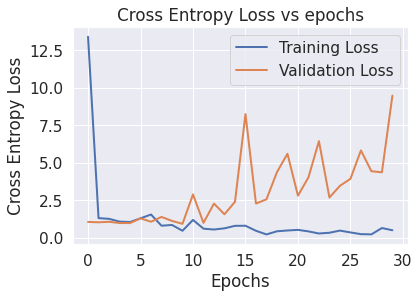

In [ ]:
# Loss Plot
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots()

ax.plot(range(epochs), train_loss_list, linewidth=2.0, label="Training Loss")
ax.plot(range(epochs), valid_loss_list, linewidth=2.0, label="Validation Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('Cross Entropy Loss vs epochs')

plt.legend()
plt.show()

In [ ]:
# load model with best validation score
best_epoch = 9
PATH = "/content/drive/MyDrive/Deep Learning/A2/P1T2/model_" + str(best_epoch)
saved_model = SkipNet().to(device)
saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()  # put model in evaluate mode

with torch.no_grad():
  y_true = 0
  y_pred = 0
  for images, labels in testing_loader:
    images = torch.tensor(images)
    images = images.to(device)
    labels = labels.to(device)
    outputs = saved_model(images)
    y_pred = outputs.cpu().numpy() # model prediction  
    y_true = labels.cpu().numpy()  # true labels
    break

# make prediction
y_pred = np.argmax(y_pred, 1)

Calculate and print accuracy.

In [ ]:
# code here
accuracy = sum(y_true == y_pred) / len(y_pred) * 100
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 71.11111111111111


Calculate and print Confusion Matrix.

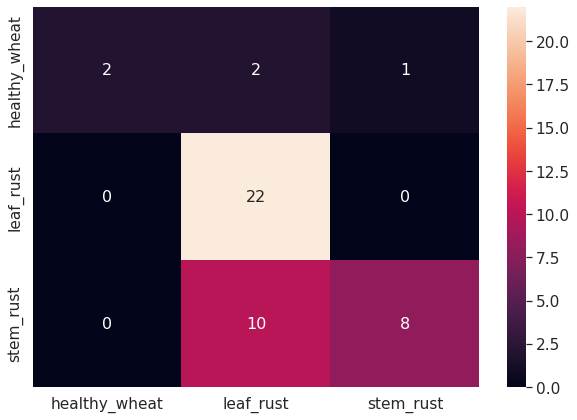

In [ ]:
# code here
temp = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(temp)

### Task 3

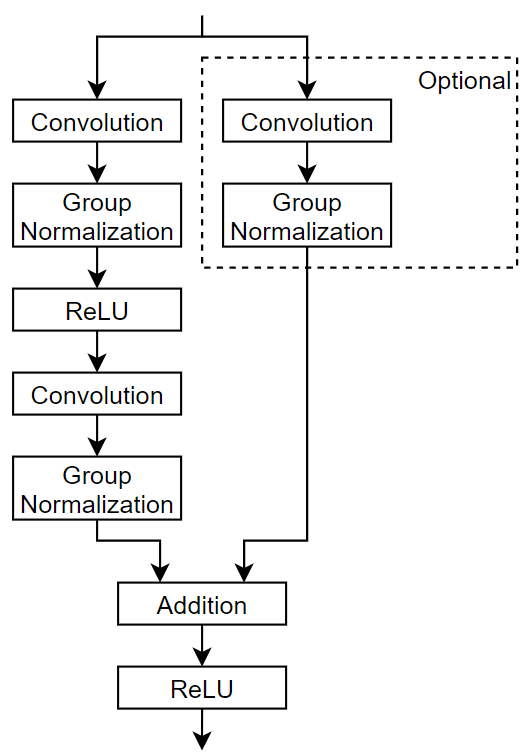

Next we will learn about a different scenario in the skip connection.


Previously, we simply added the input to the output of the convolutional layer's output. 
However, the size of the output might be modified when passed through convolutional layers so the input connection to be added to the output also has to be passed through a convolutional layer to match the output sizes.


In this model, we will modify the identity connection to match output shape.

see below image for the sample architecture.

- Kernel size = 5, Stride = 2 for first convolution ( conv2d_30)
- Kernel size = 12, Stride = 4 for second  convolution (conv2d_32)
- Kernel size = 3, Stride = 2 for third  convolution (conv2d_31)
- Dropout is 0.2
- No padding required

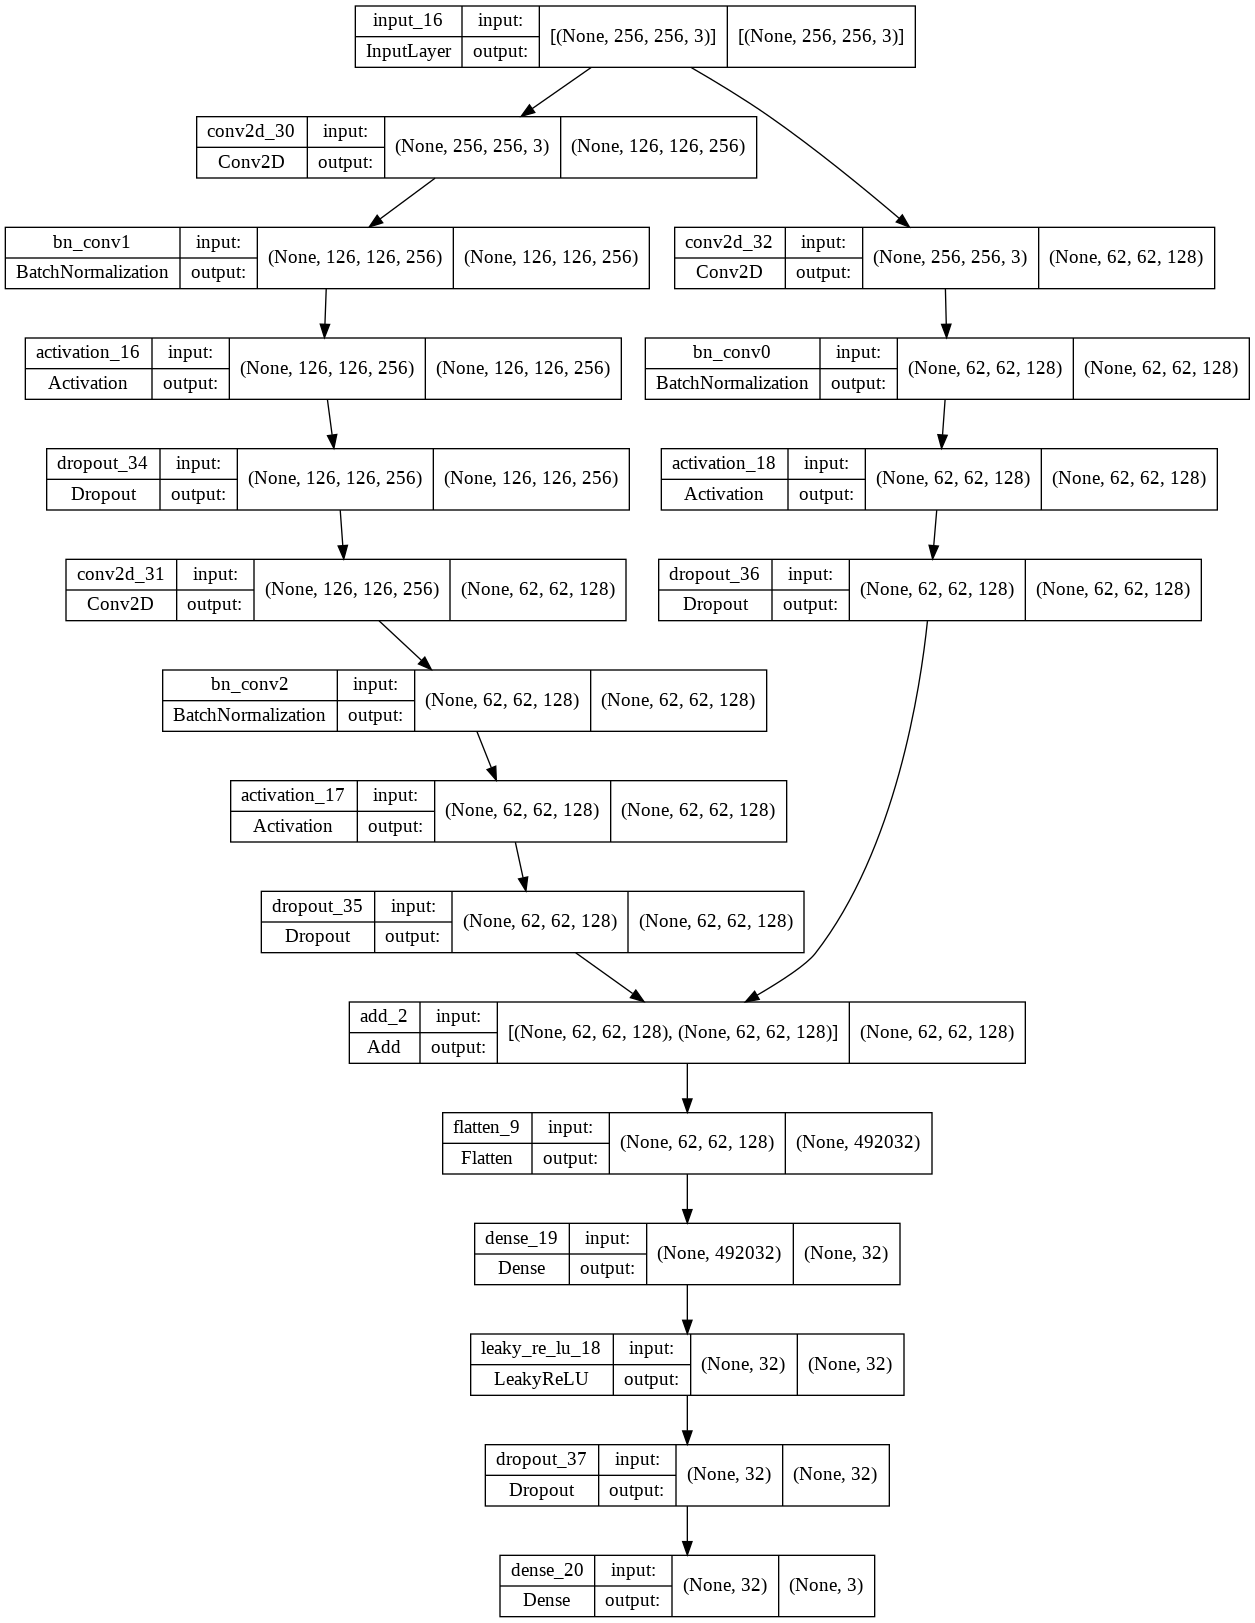

Define Network class

In [ ]:
# Code here
class SkipNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # left side first part
        self.conv30 = nn.Conv2d(3, 256, 5, stride=2, padding=0)
        self.norm1 = nn.BatchNorm2d(256)
        self.lrelu16 = nn.LeakyReLU()
        self.dropout34 = nn.Dropout(p=0.2)
        
        # left side second part
        self.conv31 = nn.Conv2d(256, 128, 3, stride=2, padding=0)
        self.norm2 = nn.BatchNorm2d(128)
        self.lrelu17 = nn.LeakyReLU()
        self.dropout35 = nn.Dropout(p=0.2)

        # right side
        self.conv32 = nn.Conv2d(3, 128, 12, stride=4, padding=0)
        self.norm0 = nn.BatchNorm2d(128)
        self.lrelu18 = nn.LeakyReLU()
        self.dropout36 = nn.Dropout(p=0.2)
        
        # addition
        self.flatten9 = nn.Flatten()
        self.dense19 = nn.Linear(492032, 32)
        self.lrelu18 = nn.LeakyReLU()
        self.dropout37 = nn.Dropout(p=0.2)
        self.dense20 = nn.Linear(32, 3)

    def forward(self, x):
        x1 = x
        # left side 
        x = self.dropout34(self.lrelu16(self.norm1(self.conv30(x))))
        x = self.dropout35(self.lrelu17(self.norm2(self.conv31(x))))
        # right side
        x1 = self.dropout36(self.lrelu18(self.norm0(self.conv32(x1))))
        # add
        x = x1 + x
        # x = self.flatten1(x)
        x = torch.flatten(x, 1)
        x = self.dense19(x)
        x = self.dense20(self.dropout37(self.lrelu18(x)))

        return x


Initialize model and cast it to device.

In [ ]:
# Code here
model = SkipNet2().to(device)

Print Summary

In [ ]:
# Code here
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
         LeakyReLU-3        [-1, 256, 126, 126]               0
           Dropout-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
         LeakyReLU-7          [-1, 128, 62, 62]               0
           Dropout-8          [-1, 128, 62, 62]               0
            Conv2d-9          [-1, 128, 62, 62]          55,424
      BatchNorm2d-10          [-1, 128, 62, 62]             256
        LeakyReLU-11          [-1, 128, 62, 62]               0
          Dropout-12          [-1, 128, 62, 62]               0
           Linear-13                   [-1, 32]      15,745,056
        LeakyReLU-14                   

Define loss, optimizer and train the new model 

In [ ]:
# Code here
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
num_training_batches = len(training_paths) / batch_size

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    counter = 0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = torch.tensor(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        counter +=1
   
    last_loss = running_loss / counter # loss per batch
    return last_loss

def validate_one_epoch(saved_models_directory):
  # Load the saved model
  PATH = saved_models_directory + str(epoch)
  saved_model = SkipNet2().to(device)
  saved_model.load_state_dict(torch.load(PATH))

  saved_model.train(False)
  saved_model.eval()

  with torch.no_grad():  
    running_vloss = 0.0
    counter = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = torch.tensor(vinputs)
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = saved_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        counter +=1
        del vinputs, vlabels, voutputs
    del saved_model
  return (running_vloss / counter).cpu().numpy()

In [ ]:
# ------ Train model on training set ------
epoch_number = 0

train_loss_list = []

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_list.append(avg_loss) # append to list for plotting

    # We don't need gradients on to do reporting
    model.train(False)

    print('LOSS train {}'.format(avg_loss))

    # Save the model's state
    model_path = '/content/drive/MyDrive/Deep Learning/A2/P1T3/model_{}'.format(epoch_number)
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


LOSS train 1.0971852737394245
EPOCH 2:
LOSS train 1.0248661627146332
EPOCH 3:
LOSS train 1.1235545643351295
EPOCH 4:
LOSS train 1.0404149615629152
EPOCH 5:
LOSS train 0.8886646699499
EPOCH 6:
LOSS train 0.746503786099228
EPOCH 7:
LOSS train 0.7899544247510758
EPOCH 8:
LOSS train 0.7269878682087768
EPOCH 9:
LOSS train 0.6220947129821236
EPOCH 10:
LOSS train 0.7579204065047882
EPOCH 11:
LOSS train 0.922758145977489
EPOCH 12:
LOSS train 0.821327221241187
EPOCH 13:
LOSS train 0.5353786195739965
EPOCH 14:
LOSS train 0.3875218774456615
EPOCH 15:
LOSS train 0.4835428480080075
EPOCH 16:
LOSS train 0.36363790394823975
EPOCH 17:
LOSS train 0.3372385069603545
EPOCH 18:
LOSS train 0.30502805711279796
EPOCH 19:
LOSS train 0.2588225668769155
EPOCH 20:
LOSS train 0.19793071607735288
EPOCH 21:
LOSS train 1.4002230924270784
EPOCH 22:
LOSS train 0.09920791078179582
EPOCH 23:
LOSS train 0.06877700782854132
EPOCH 24:
LOSS train 0.2481490720346745
EPOCH 25:
LOSS train 0.12377915942557717
EPOCH 26:
LOSS tra

In [ ]:
# Find the model with least validaiton loss
epoch_number = 0
best_vloss = 1_000_000.
valid_loss_list = []
best_epoch_number = 0

model_directory = '/content/drive/MyDrive/Deep Learning/A2/P1T3/model_'

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))
    torch.cuda.empty_cache()
    avg_vloss = validate_one_epoch(model_directory)
    valid_loss_list.append(avg_vloss) # append to list for plotting
    print('LOSS valid {}'.format(avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch_number = epoch

    epoch_number += 1

print("model with least validation loss was at epoch {}".format(best_epoch_number))

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


LOSS valid 0.8050403594970703
EPOCH 2:
LOSS valid 0.7782182097434998
EPOCH 3:
LOSS valid 0.6896548867225647
EPOCH 4:
LOSS valid 0.6687779426574707
EPOCH 5:
LOSS valid 0.7408835291862488
EPOCH 6:
LOSS valid 0.7481731176376343
EPOCH 7:
LOSS valid 0.6473866105079651
EPOCH 8:
LOSS valid 1.1577399969100952
EPOCH 9:
LOSS valid 0.7701343297958374
EPOCH 10:
LOSS valid 1.3252012729644775
EPOCH 11:
LOSS valid 2.3511850833892822
EPOCH 12:
LOSS valid 1.0216071605682373
EPOCH 13:
LOSS valid 1.1540052890777588
EPOCH 14:
LOSS valid 0.7191359400749207
EPOCH 15:
LOSS valid 1.355748176574707
EPOCH 16:
LOSS valid 0.6184476017951965
EPOCH 17:
LOSS valid 0.7010536193847656
EPOCH 18:
LOSS valid 0.7777902483940125
EPOCH 19:
LOSS valid 0.9921264052391052
EPOCH 20:
LOSS valid 2.4015116691589355
EPOCH 21:
LOSS valid 1.8928039073944092
EPOCH 22:
LOSS valid 1.0996837615966797
EPOCH 23:
LOSS valid 1.6645373106002808
EPOCH 24:
LOSS valid 1.4528216123580933
EPOCH 25:
LOSS valid 1.9099687337875366
EPOCH 26:
LOSS vali

Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

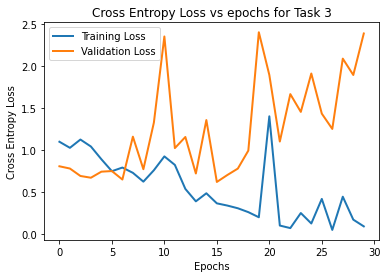

In [ ]:
# Loss Plot
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots()

ax.plot(range(epochs), train_loss_list, linewidth=2.0, label="Training Loss")
ax.plot(range(epochs), valid_loss_list, linewidth=2.0, label="Validation Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('Cross Entropy Loss vs epochs for Task 3')

plt.legend()
plt.show()

In [ ]:
# load model with best validation score
best_epoch = 15
PATH = "/content/drive/MyDrive/Deep Learning/A2/P1T3/model_" + str(best_epoch)
saved_model = SkipNet2().to(device)
saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()  # put model in evaluate mode

with torch.no_grad():
  y_true = 0
  y_pred = 0
  for images, labels in testing_loader:
    images = torch.tensor(images)
    images = images.to(device)
    labels = labels.to(device)
    outputs = saved_model(images)
    y_pred = outputs.cpu().numpy() # model prediction  
    y_true = labels.cpu().numpy()  # true labels
    break

# make prediction
y_pred = np.argmax(y_pred, 1)

Calculate and print accuracy.

In [ ]:
# code here
accuracy = sum(y_true == y_pred) / len(y_pred) * 100
print("Accuracy of model is {}".format(accuracy))

Accuracy of model is 71.91011235955057


Calculate and print Confusion Matrix.

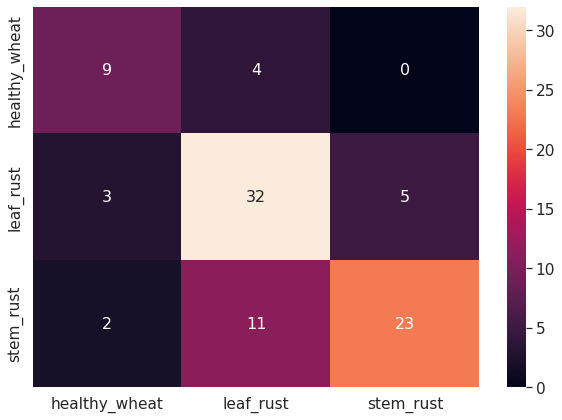

In [ ]:
# code here
temp = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(temp)

### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer: 
- Overfitting is when the during training of data, the model parameters like weight and bias are updated to values that are overly specified to the training data. This causes the model to perform with high accuracy on the train set. However, the model performs poorly on the test set. 
- Drop-out layers have been inserted in each model, that prevent overfitting due to a layer's over-reliance on a few inputs. 
- In this assignment, I formed a validation set from the testing data (made a 50-50 split) and I choose the model that performs best on the validation. I have also shown plots of validaiton and train cross entropy loss error to highlight this effect.


What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer: 
- Class imbalance is when the distribution of train and/or test examples of a classification problem of known classes is skewed or biased.
- Class imbalance has a negative impact on equally training the model because the model becomes more specific to the majority class or classes resulting in poor predictive performance especially for the minority class
- This training set has class imbalance. From the code below that counts the number of train examples in each class, it is shown that there are 113 train examples for healthy wheat. This number is more than half the number of train examples in leaf rust (286) and stem rust (300). This shows that the classes are skewed towards leaf rust and stem rust, making healthy wheat a minority class

In [ ]:
# Code here
files = glob.glob("/content/WheatDiseaseDataset/train/healthy_wheat/*", recursive = False)
print("healthy wheat train examples = {}".format(len(files)))

healthy wheat train examples = 113


In [ ]:
files = glob.glob("/content/WheatDiseaseDataset/train/leaf_rust/*", recursive = False)
print("leaf rust train examples = {}".format(len(files)))

leaf rust train examples = 286


In [ ]:
files = glob.glob("/content/WheatDiseaseDataset/train/stem_rust/*", recursive = False)
print("stem rust train examples = {}".format(len(files)))

stem rust train examples = 300
